In [2]:
###LOAD RELEVANT LIBRARIES###
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

1. READ IN THE DATA

In [3]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [4]:
if 'id' in df.columns:
    df.drop("id", axis=1, inplace=True)
df = df[df['gender'] != 'Other']
X = df.drop("stroke", axis=1)
df.drop_duplicates(inplace=True)
y = df["stroke"]
numeric_features = ["age", "avg_glucose_level", "bmi"]
categorical_features = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]


2. SHAPE OF THE DATA

In [5]:

print("Number of rows (observations):", df.shape[0])
print("Number of columns (features):", df.shape[1])

for dtype in df.dtypes.unique():
    print(f"\nColumns with data type {dtype}:\n", df.select_dtypes(include=[dtype]).columns.tolist())

print("Numerical columns:", df.select_dtypes(include=['number']).shape[1])
print("Categorical columns:", df.select_dtypes(include=['object', 'bool']).shape[1])

print(df.head())


Number of rows (observations): 5109
Number of columns (features): 11

Columns with data type object:
 ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

Columns with data type float64:
 ['age', 'avg_glucose_level', 'bmi']

Columns with data type int64:
 ['hypertension', 'heart_disease', 'stroke']
Numerical columns: 6
Categorical columns: 5
   gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1  Female  61.0             0              0          Yes  Self-employed   
2    Male  80.0             0              1          Yes        Private   
3  Female  49.0             0              0          Yes        Private   
4  Female  79.0             1              0          Yes  Self-employed   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             202.21  

3. ANY MISSING VALUES?

In [6]:
missing = df.isnull().sum()
missing = missing[missing > 0]
print("Columns with missing values:\n", missing)

Columns with missing values:
 bmi    201
dtype: int64


4. IS THE TARGET VARIABLE BALANCED?

In [7]:
stroke_counts = df['stroke'].value_counts()
stroke_ratio = df['stroke'].value_counts(normalize=True)

print("Stroke Class Distribution:")
print(stroke_counts)

print("\nClass Proportions:")
print(stroke_ratio)


Stroke Class Distribution:
stroke
0    4860
1     249
Name: count, dtype: int64

Class Proportions:
stroke
0    0.951262
1    0.048738
Name: proportion, dtype: float64


5. PREPROCESSING

In [8]:
df = df.drop(columns=['id'], errors='ignore') 
df['bmi_age_ratio'] = df['bmi'] / df['age']
df['glucose_age_ratio'] = df['avg_glucose_level'] / df['age']
df['bmi'] = df['bmi'].fillna(df['bmi'].median())
df.head()


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_age_ratio,glucose_age_ratio
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,0.546269,3.413284
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1,NaN,3.314918
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,0.406250,1.324000
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,0.702041,3.494490
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,0.303797,2.204051


6. INTERESTING FEATURES

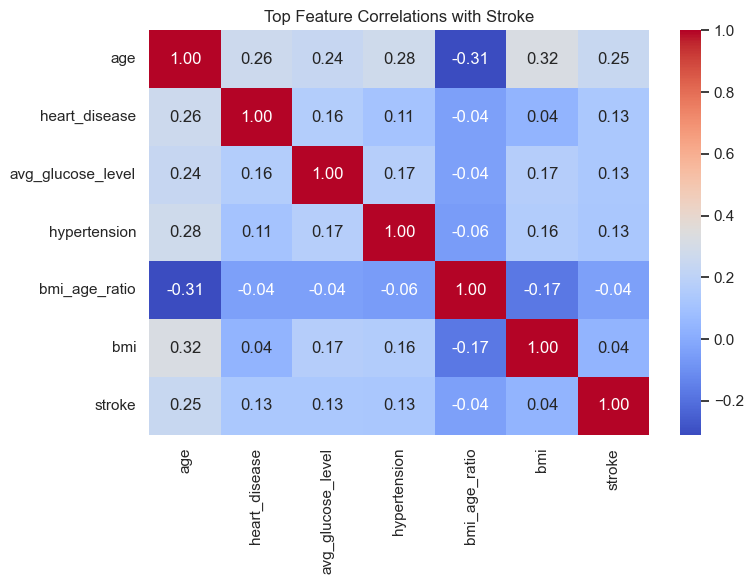

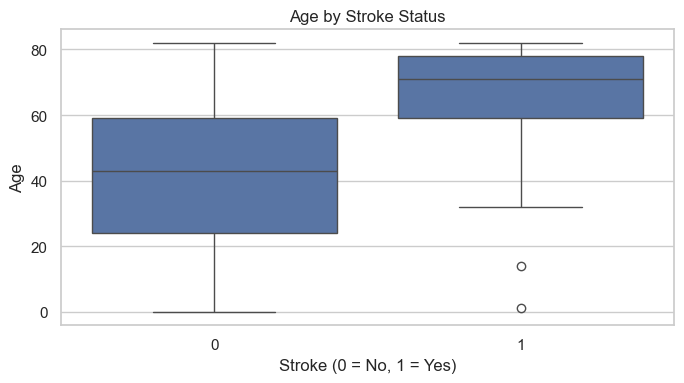

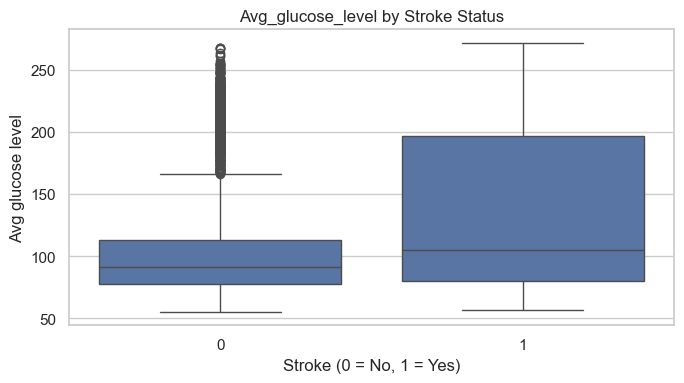

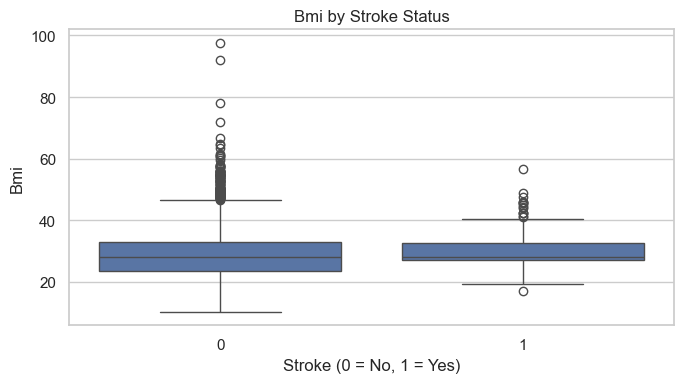

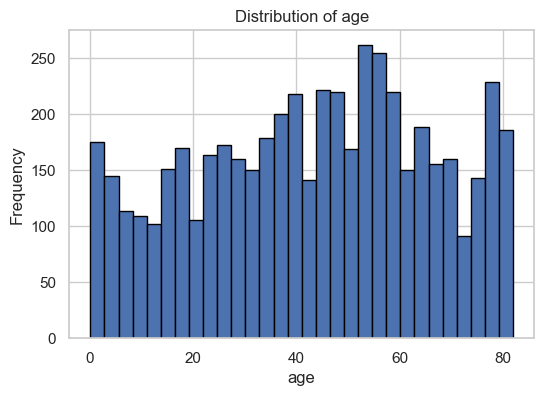

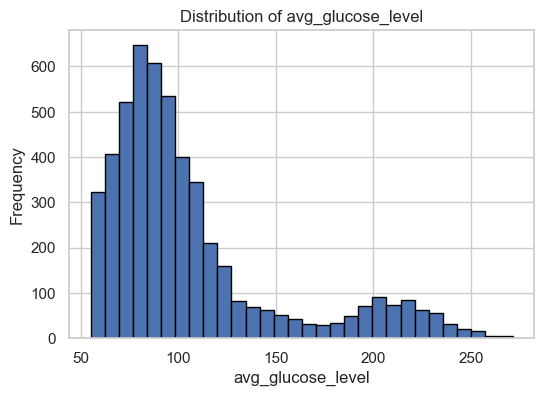

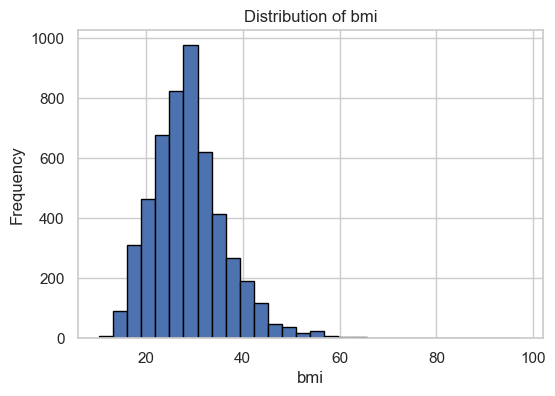

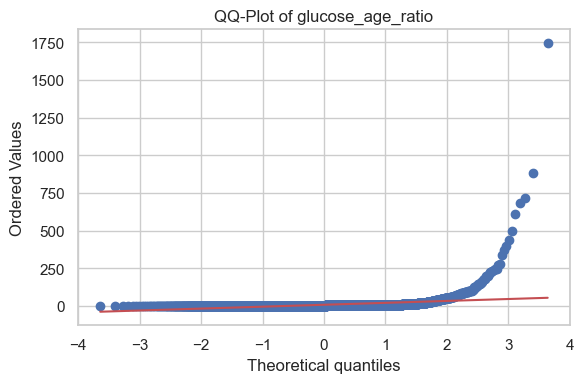

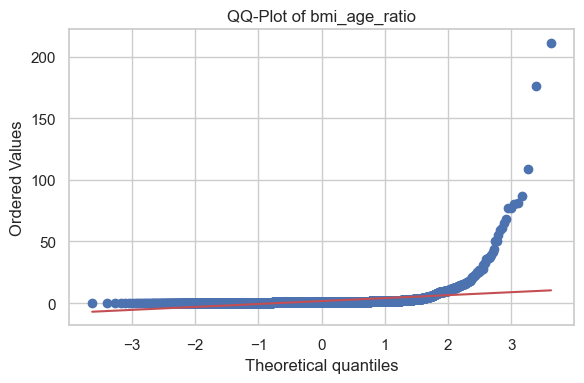

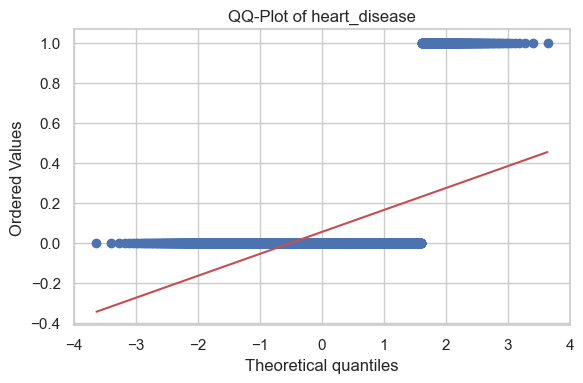

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(style="whitegrid")

# === 1. Correlation Heatmap ===
correlations = df.corr(numeric_only=True)['stroke'].drop('stroke').sort_values(key=abs, ascending=False)
top_corr_features = correlations.head(6).index

plt.figure(figsize=(8, 6))
sns.heatmap(df[top_corr_features.tolist() + ['stroke']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top Feature Correlations with Stroke")
plt.tight_layout()
plt.show()

# === 2. Boxplots: Stroke vs No Stroke ===
features_to_plot = ['age', 'avg_glucose_level', 'bmi'] 

for feature in features_to_plot:
    plt.figure(figsize=(7, 4))
    sns.boxplot(x='stroke', y=feature, data=df)
    plt.title(f"{feature.capitalize()} by Stroke Status")
    plt.xlabel("Stroke (0 = No, 1 = Yes)")
    plt.ylabel(feature.replace("_", " ").capitalize())
    plt.tight_layout()
    plt.show()

# === 3. Histograms ===
numeric_features = ['age', 'avg_glucose_level', 'bmi']

for col in numeric_features:
    plt.figure(figsize=(6, 4))
    plt.hist(df[col], bins=30, edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# === 4. QQ-Plots for Skewed Features ===
num_cols = df.select_dtypes(include='number').columns.tolist()
skew_vals = df[num_cols].skew().sort_values(key=abs, ascending=False)

most_skewed = [col for col in skew_vals.index if col != 'stroke'][:3]

for feature in most_skewed:
    plt.figure(figsize=(6, 4))
    stats.probplot(df[feature].dropna(), dist="norm", plot=plt)
    plt.title(f"QQ-Plot of {feature}")
    plt.tight_layout()
    plt.show()



7. Splitting data and train-validation-test split

In [10]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['stroke'])
y = df['stroke']
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=17, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=17, stratify=y_temp
)
print(f'Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_valid)}')
print(f'Test set size: {len(X_test)}')


Training set size: 4087
Validation set size: 511
Test set size: 511


###Model Training Strategy
We evaluate multiple classifiers under both unbalanced and SMOTE-balanced
settings using unified preprocessing pipelines and GridSearchCV.
Performance is assessed using weighted F1-score to account for class imbalance
in stroke prediction.

8. Preprocessing pipeline

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd

df['bmi'] = df['bmi'].fillna(df['bmi'].median())

X = df.drop(columns=['avg_glucose_level'])  
y = df['avg_glucose_level']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

numeric_cols = ['age', 'bmi']
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
pass_through_cols = ['hypertension', 'heart_disease']
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessing = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols),
    ('pass', 'passthrough', pass_through_cols)
], sparse_threshold=0)

trans_data = preprocessing.fit_transform(X_train)

transformed_df = pd.DataFrame(
    trans_data,
    columns=preprocessing.get_feature_names_out(),
    index=X_train.index
)

print(transformed_df.head())


      num__age  num__bmi  cat__gender_Female  cat__gender_Male  \
802   1.588594 -0.048907                 0.0               1.0   
3927  0.836881  0.957224                 1.0               0.0   
2337 -0.976075  0.621847                 1.0               0.0   
3910 -0.533891  0.196176                 0.0               1.0   
1886 -0.533891 -1.158232                 1.0               0.0   

      cat__ever_married_No  cat__ever_married_Yes  cat__work_type_Govt_job  \
802                    0.0                    1.0                      0.0   
3927                   0.0                    1.0                      0.0   
2337                   1.0                    0.0                      0.0   
3910                   0.0                    1.0                      1.0   
1886                   1.0                    0.0                      0.0   

      cat__work_type_Never_worked  cat__work_type_Private  \
802                           0.0                     0.0   
3927        

In [11]:
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

# Define features and target
X = df.drop(columns=['avg_glucose_level'])
y = df['avg_glucose_level']

# === Split Dataset ===
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=17, stratify=None)
X_valid, X_test = train_test_split(X_temp, test_size=0.5, random_state=17)
y_valid, y_test = train_test_split(y_temp, test_size=0.5, random_state=17)

In [12]:
# === Load and Preprocess Stroke Dataset ===
import pandas as pd
from pathlib import Path

# Load the dataset
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

# Drop irrelevant or ID columns
df = df.drop(columns=['id'], errors='ignore')

# Feature engineering: create ratios
df['bmi_age_ratio'] = df['bmi'] / df['age']
df['glucose_age_ratio'] = df['avg_glucose_level'] / df['age']

# Handle missing values in numeric columns
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

# If target column is not already integer, convert it
df['stroke'] = df['stroke'].astype(int)

# Final dataset is ready for splitting
print(df.head())


   gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1  Female  61.0             0              0          Yes  Self-employed   
2    Male  80.0             0              1          Yes        Private   
3  Female  49.0             0              0          Yes        Private   
4  Female  79.0             1              0          Yes  Self-employed   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  \
0          Urban             228.69  36.6  formerly smoked       1   
1          Rural             202.21  28.1     never smoked       1   
2          Rural             105.92  32.5     never smoked       1   
3          Urban             171.23  34.4           smokes       1   
4          Rural             174.12  24.0     never smoked       1   

   bmi_age_ratio  glucose_age_ratio  
0       0.546269           3.413284  
1            NaN           3.314918  
2       

In [13]:
from sklearn.model_selection import train_test_split

# === Split Stroke Dataset ===
X = df.drop(columns=['stroke'])
y = df['stroke'].astype(int)  # Ensure the target is binary (0 or 1)

# First split: 80% training, 20% temp (for validation and testing)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=17, stratify=y
)

# Second split: split temp into 50% validation, 50% test (10% each of full data)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=17, stratify=y_temp
)


In [14]:
# === Define Models ===
models_with_grids = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'classifier__C': [0.01, 0.1, 1, 10]}),
    'Decision Tree': (DecisionTreeClassifier(), {'classifier__max_depth': [3, 5, 10, 15]}),
    'SVC': (SVC(probability=True), {'classifier__C': [0.1, 1], 'classifier__kernel': ['linear', 'rbf'], 'classifier__gamma': ['scale', 'auto']}),
    'Random Forest': (RandomForestClassifier(), {'classifier__n_estimators': [50, 100], 'classifier__max_depth': [5, 10]})
}

no_grid_models = {
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, validation_fraction=0.1, n_iter_no_change=5, random_state=42),
    'Neural Net': MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', max_iter=300, random_state=42)
}


In [15]:
# === Evaluation Function ===
results = []

def evaluate_model(name, model, X_train, y_train, X_valid, y_valid, balanced=False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_proba = model.predict_proba(X_valid)[:, 1]
    f1 = classification_report(y_valid, y_pred, output_dict=True)['weighted avg']['f1-score']
    roc = roc_auc_score(y_valid, y_proba)
    results.append({
        'Model': name + (' (Balanced)' if balanced else ' (Unbalanced)'),
        'Validation F1': round(f1, 4),
        'Validation ROC AUC': round(roc, 4)
    })


In [133]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numerical_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE



# Pipeline WITHOUT balancing

preprocessing = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

print("=== Results WITHOUT SMOTE ===")
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Pipeline WITH SMOTE balancing
model_smote_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000))
])

print("\n=== Results WITH SMOTE ===")
model_smote_pipeline.fit(X_train, y_train)
y_pred_smote = model_smote_pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))


=== Results WITHOUT SMOTE ===
[[486   0]
 [ 25   0]]


c:\Users\sthab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sthab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sthab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       486
           1       0.00      0.00      0.00        25

    accuracy                           0.95       511
   macro avg       0.48      0.50      0.49       511
weighted avg       0.90      0.95      0.93       511


=== Results WITH SMOTE ===
[[348 138]
 [  4  21]]
              precision    recall  f1-score   support

           0       0.99      0.72      0.83       486
           1       0.13      0.84      0.23        25

    accuracy                           0.72       511
   macro avg       0.56      0.78      0.53       511
weighted avg       0.95      0.72      0.80       511



8. MODEL TRAINING AND RESULTS

In [21]:
# === Run Unbalanced Models ===
for name, (model, params) in models_with_grids.items():
    pipe = Pipeline([
        ('preprocessing', preprocessing),
        ('classifier', model)
    ])
    grid = GridSearchCV(pipe, param_grid=params, scoring='f1_weighted', cv=5)
    grid.fit(X_train, y_train)
    evaluate_model(name, grid.best_estimator_, X_train, y_train, X_valid, y_valid, balanced=False)

for name, model in no_grid_models.items():
    pipe = Pipeline([
        ('preprocessing', preprocessing),
        ('classifier', model)
    ])
    evaluate_model(name, pipe, X_train, y_train, X_valid, y_valid, balanced=False)



# === Run Balanced Models ===
for name, (model, params) in models_with_grids.items():
    pipe = ImbPipeline([
        ('preprocessing', preprocessing),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    grid = GridSearchCV(pipe, param_grid=params, scoring='f1_weighted', cv=5)
    grid.fit(X_train, y_train)
    evaluate_model(name, grid.best_estimator_, X_train, y_train, X_valid, y_valid, balanced=True)

for name, model in no_grid_models.items():
    pipe = ImbPipeline([
        ('preprocessing', preprocessing),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    evaluate_model(name, pipe, X_train, y_train, X_valid, y_valid, balanced=True)

c:\Users\sthab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sthab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sthab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [22]:
# === Final Results Table ===
results_df = pd.DataFrame(results).sort_values(by='Validation ROC AUC', ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df = results_df.round(4)
print(results_df)


                               Model  Validation F1  Validation ROC AUC
0     Gradient Boosting (Unbalanced)         0.9272              0.8763
1     Gradient Boosting (Unbalanced)         0.9272              0.8763
2   Logistic Regression (Unbalanced)         0.9272              0.8596
3   Logistic Regression (Unbalanced)         0.9272              0.8596
4     Logistic Regression (Balanced)         0.8052              0.8547
5     Logistic Regression (Balanced)         0.8052              0.8547
6         Random Forest (Unbalanced)         0.9272              0.8513
7         Decision Tree (Unbalanced)         0.9272              0.8267
8         Decision Tree (Unbalanced)         0.9272              0.8267
9         Random Forest (Unbalanced)         0.9272              0.8206
10      Gradient Boosting (Balanced)         0.8735              0.8013
11          Random Forest (Balanced)         0.8863              0.7918
12                    SVC (Balanced)         0.8442             